In [10]:
import torch
from vesselExtractor import *
from supportFunctions import *
from segment_anything import sam_model_registry, SamPredictor
import glob
import matplotlib.pyplot as plt
import stackview
import napari
import numpy as np
from IPython.display import display
import ipywidgets as widgets
import tifffile
import tkinter as tk
from tkinter import filedialog
import skimage
import pandas as pd

## Notebook Parameters 


In [41]:
# Where to start the arclength, 270 for half, for upper wedge 235, for 360 use 0 (but it doesn't matter)
startAng = 225

# How long the wedge is, 90 for quater, 180 for half, 360 for the who thing
arcLeng = 90

In [12]:
# Create a Tk root window (but keep it hidden)
root = tk.Tk()
root.withdraw()

# Open file selection dialog for a single file
file = filedialog.askopenfilename(
    title="Select an MP4 File",
    filetypes=[("MP4 files", "*.mp4")],
    initialdir="../shortclips/Short clips (before and after wash)"
)

print("Selected file:", file)

Selected file: /mnt/5404b8a5-71b7-4464-9a1e-b40cd26fac58/Data_Drive/Wissam/Eye_Surgery/shortclips/Short clips (before and after wash)/2023-02_Phaco+LIO+Hydrus_GD.mp4


In [13]:
def load_mp4_as_mmap(mp4_path, mmap_path="video_frames.mmap", dtype=np.uint8):
    """
    Load an MP4 file as a memory-mapped NumPy array.

    Parameters:
        mp4_path (str): Path to the MP4 file.
        mmap_path (str): Path to store the memory-mapped file.
        dtype (data-type): Data type for the NumPy array. Default is np.uint8.

    Returns:
        np.memmap: Memory-mapped NumPy array of video frames.
    """
    # Open the video file using OpenCV
    video_capture = cv2.VideoCapture(mp4_path)
    if not video_capture.isOpened():
        raise ValueError(f"Cannot open video file: {mp4_path}")
    
    # Get video properties
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    channels = 3  # Assuming the video is in color (BGR format)

    # Prepare a memory-mapped array
    mmap_shape = (frame_count, frame_height, frame_width, channels)
    mmap_array = np.memmap(mmap_path, dtype=dtype, mode="w+", shape=mmap_shape)

    # Read and store frames into the memory-mapped array
    for i in range(frame_count):
        ret, frame = video_capture.read()
        if not ret:
            print(f"Warning: Could not read frame {i}.")
            break
        mmap_array[i] = frame[..., ::-1]

    # Release video capture and flush the memory-mapped file
    video_capture.release()
    mmap_array.flush()

    return mmap_array
movie = load_mp4_as_mmap(file)

In [15]:
nb_viewer = stackview.slice(movie, continuous_update=True)
display(nb_viewer)

# Create an Output widget
output = widgets.Output()
# Create a button widget
btnF1 = widgets.Button(description="Select Frame 1")
btnF2 = widgets.Button(description="Select Frame 2")

img1 = 0 
img2 = 0 
startIdx = 0 
stopIdx = 0 
def clickF1(b):
    global nb_viewer, movie, img1, startIdx  # Make it refer to the global variable
    startIdx = nb_viewer.children[1].value  # Get slider value
    img1 = movie[startIdx]
    
def clickF2(b):
    global nb_viewer, movie, img2, stopIdx  # Make it refer to the global variable
    stopIdx = nb_viewer.children[1].value  # Get slider value
    img2 = movie[stopIdx] 
       
# Attach function to button click event
btnF1.on_click(clickF1)
btnF2.on_click(clickF2)

# Display the button and output widget
display(btnF1, btnF2, output)

Button(description='Select Frame 1', style=ButtonStyle())

Button(description='Select Frame 2', style=ButtonStyle())

Output()

Frames 0 and  445 were seleceted


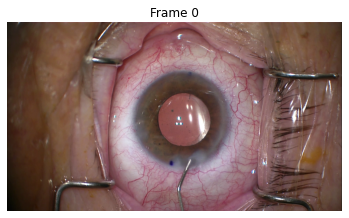

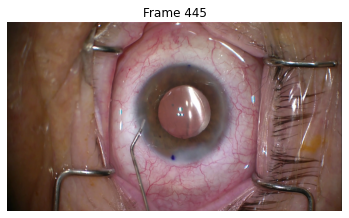

In [16]:
print("Frames {} and  {} were seleceted".format(startIdx, stopIdx))

plt.imshow(img1)
plt.title('Frame {}'.format(startIdx))
plt.axis('off')
plt.show()

plt.imshow(img2)
plt.title('Frame {}'.format(stopIdx))
plt.axis('off')
plt.show()

### Use the Napari Window to add points to both the Sclera and Pupil point layers. Leave the Napari window open to inspect results.

In [17]:
eyeMasks1 = napari.Viewer(title="Frame 1")
eyeMasks1.add_image(img1)
pupil1, sclera1 = [], []
eyeMasks1.add_points(sclera1, name='Sclera')
eyeMasks1.add_points(pupil1, name='Pupil')

eyeMasks2 = napari.Viewer(title="Frame 2")
eyeMasks2.add_image(img2)
pupil2, sclera2 = [], []
eyeMasks2.add_points(sclera2, name='Sclera')
eyeMasks2.add_points(pupil2, name='Pupil')

<Points layer 'Pupil' at 0x7f690ed2da20>

In [18]:
sclera1 = eyeMasks1.layers[1].data
sclera1 = sclera1[:, [1, 0]]
pupil1 = eyeMasks1.layers[2].data
pupil1= pupil1[:, [1, 0]]

sclera2 = eyeMasks2.layers[1].data
sclera2 = sclera2[:, [1, 0]]
pupil2 = eyeMasks2.layers[2].data
pupil2= pupil2[:, [1, 0]]


### Generate masks for pupil and sclera 

In [19]:
# Load SAM1 on the GPU
sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

def returnMasks(img, predictor, sclera,  pupil, viewer=None):
    predictor.set_image(img)
    
    sclera_mask, _, _ = predictor.predict(
        point_coords=sclera,
        point_labels=[1]*sclera.shape[0],
        box=None,
        multimask_output=False,
    )
    pupil_mask, _, _ = predictor.predict(
        point_coords=pupil,
        point_labels=[1]*pupil.shape[0],
        box=None,
        multimask_output=False,
    )
    sclera_mask[pupil_mask==1]=0
    if viewer is not None:
        viewer.add_labels(sclera_mask)
        viewer.add_labels(pupil_mask)
    return sclera_mask, pupil_mask

/home/peter/.local/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [20]:
scelraT1, pupilT1 = returnMasks(img1, predictor, sclera1, pupil1, eyeMasks1)
scelraT2, pupilT2 = returnMasks(img2, predictor, sclera2, pupil2, eyeMasks2)

(1, 1080, 1920)

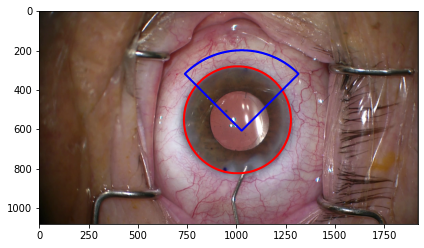

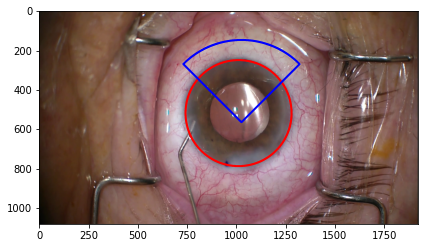

In [45]:
pupil1Mask1, scelraT1_crop = plot_wedges(img1, pupilT1[0,::], scelraT1[0,::], pupil_arc=(0, 360), sclera_arc=(startAng, arcLeng))
pupil1Mask2, scelraT2_crop = plot_wedges(img2, pupilT2[0,::], scelraT2[0,::], pupil_arc=(0, 360), sclera_arc=(startAng, arcLeng))


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
model_path = "BV_Net128.pth"  # Path to your saved model file
loaded_model = load_model(model_path, device, in_channels=1, classes=1)
def returnBloodVessels(img, model, pupil_mask, sclera_mask, viewer):
    bloodVessels = sliding_window_inference_2d(loaded_model, img, device, threshold=0.15)
    bloodVessels[pupil_mask[::]==1]=0
    bloodVessels[sclera_mask[::]==0]=0
    viewer.add_labels(bloodVessels)
    return bloodVessels

Model loaded from BV_Net128.pth


In [46]:
vesselsT1 = returnBloodVessels(img1, loaded_model, pupil1Mask1, scelraT1_crop, eyeMasks1)
vesselsT2 = returnBloodVessels(img1, loaded_model, pupil1Mask2, scelraT2_crop, eyeMasks2)

In [47]:
pctBV1 = np.sum(vesselsT1) / np.sum(scelraT1_crop)
pctBV2 = np.sum(vesselsT2) / np.sum(scelraT2_crop)

In [48]:
def vesselBifurcations(bloodVessels): 
    skelVessles = skimage.morphology.skeletonize(bloodVessels).astype(np.int8)
    _points = np.where(skelVessles==1)
    branchPoints = []
    for coords in zip(_points[0], _points[1]):
        skellyWind = skelVessles[coords[0]-1:coords[0]+2, coords[1]-1:coords[1]+2].copy()
        if  np.sum(skellyWind) ==4:
            if np.sum(skellyWind[1, :])==3 or np.sum(skellyWind[:,1])==3:
                if np.sum(skellyWind[0, :])==2 or np.sum(skellyWind[:,0])==2:
                    continue
                if np.sum(skellyWind[2, :])==2 or np.sum(skellyWind[:,2])==2:
                    continue
                #if np.sum(skellyWind[0, :])<2 or np.sum(skellyWind[:,0])<2:
    
                if  np.sum(skellyWind) - 1 >=3:
                    branchPoints.append(coords)
        if np.sum(skellyWind) ==4:
            if skellyWind[0,0]+ skellyWind[1,1]+skellyWind[2,2] == 3:
                if np.sum(skellyWind[1, :])==1 and np.sum(skellyWind[:,1])==1:
                    branchPoints.append(coords)
    
            if skellyWind[0,2]+ skellyWind[1,1]+skellyWind[2,0] == 3:
                if np.sum(skellyWind[1, :])==1 and np.sum(skellyWind[:,1])==1:
                    branchPoints.append(coords)
            _testWindow = skellyWind.copy()
            _testWindow[1,1] = 0
            if np.sum(_testWindow[0, :])==1 and np.sum(_testWindow[1, :])==1 and np.sum(_testWindow[2, :])==1:
                if np.sum(_testWindow[:, 0])==1 and np.sum(_testWindow[:, 1])==1 and np.sum(_testWindow[:, 2])==1:
                    branchPoints.append(coords) 
    
            if np.sum(_testWindow[0, :])==1 and np.sum(_testWindow[1, :])==1 and np.sum(_testWindow[2, :])==1:
                if np.sum(_testWindow[:, 0])==1 and np.sum(_testWindow[:, 1])==1 and np.sum(_testWindow[:, 2])==1:
                    branchPoints.append(coords)
    
            if (np.sum(_testWindow[0, :])==2 and np.sum(_testWindow[2, :])==1) or (np.sum(_testWindow[0, :])==1 and np.sum(_testWindow[2, :])==2):
                if np.sum(_testWindow[:, 0])==1 and np.sum(_testWindow[:, 1])==1 and np.sum(_testWindow[:, 2])==1:
        
                    branchPoints.append(coords)
            if (np.sum(_testWindow[:, 0])==2 and np.sum(_testWindow[:, 2])==1) or (np.sum(_testWindow[:, 0])==1 and np.sum(_testWindow[:, 2])==2):
                if np.sum(_testWindow[:, 0])==1 and np.sum(_testWindow[:, 1])==1 and np.sum(_testWindow[:, 2])==1:
        
                    branchPoints.append(coords)

    return len(branchPoints)

In [49]:
bp1 = vesselBifurcations(vesselsT1)
bp2 = vesselBifurcations(vesselsT2) 

In [58]:
import numpy as np

def quantify_red_pixels(img, mask, red_threshold=150, green_threshold=100, blue_threshold=100):

    # Apply mask to the image
    masked_pixels = img[mask == 1]

    # Count red pixels (red > threshold, green & blue below thresholds)
    red_pixels = np.sum((masked_pixels[:, 0] >= red_threshold) & 
                        (masked_pixels[:, 1] <= green_threshold) & 
                        (masked_pixels[:, 2] <= blue_threshold))
    
    # Calculate percentage
    total_pixels = len(masked_pixels)
    red_percentage = (red_pixels / total_pixels) * 100 if total_pixels > 0 else 0

    return red_percentage

red_percentage1 = quantify_red_pixels(img1, scelraT1_crop)
red_percentage2 = quantify_red_pixels(img2, scelraT2_crop)


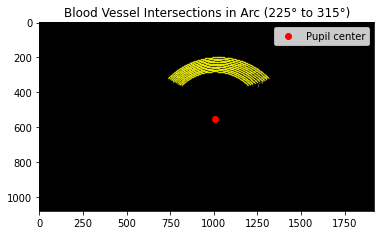

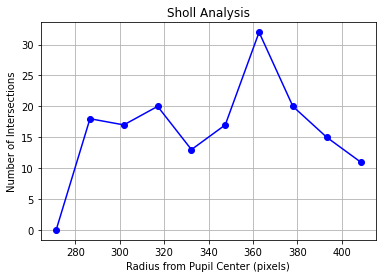

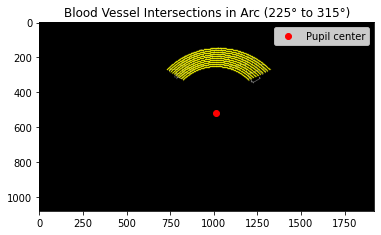

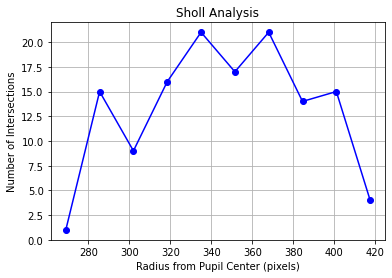

In [51]:
from skimage.morphology import skeletonize

vessel_mask_skeleton1 = skeletonize(vesselsT1)

radii1, intersections1 = plot_sholl_analysis(pupilT1[0,::], scelraT1[0,::], vessel_mask_skeleton1,
                                           num_circles=10, start_angle=startAng, arc_length=arcLeng)
vessel_mask_skeleton2 = skeletonize(vesselsT2)
radii2, intersections2 = plot_sholl_analysis(pupilT2[0,::], scelraT2[0,::], vessel_mask_skeleton2,
                                           num_circles=10, start_angle=startAng, arc_length=arcLeng)

In [59]:
results = {
    "File" : os.path.basename(file),
    "Frame1" : startIdx,
    "Frame2" : startIdx,
    "T1 Area %" : pctBV1,
    "T1 Red %" : red_percentage1,
    "T1 Bifurcations": bp1,
    "T2 Area %" : pctBV2,
    "T2 Red %" : red_percentage2,
    "T2 Bifurcations": bp2,
    "Abs Area Change": np.sum(vesselsT2) - np.sum(vesselsT1),
    "Pct Area Change": (np.sum(vesselsT2)/np.sum(vesselsT1)) * 100,
    "Abs Bifurcations Change": bp2 - bp1,
    "Pct Bifurcations Change": (bp2/bp1) * 100,
    "Rel Red Change": (red_percentage2/red_percentage1) * 100,
    "Intersections T1": intersections1,
    "Intersections T2": intersections2,
}

In [60]:
df = pd.DataFrame.from_dict([results])

In [61]:
# Define output directory
output_dir = "output/"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print("Output directory created (if not existing):", output_dir)

csv_filename = "results_start{}_arclen{}.csv".format(startAng, arcLeng)

# Check if the CSV already exists
if os.path.exists(output_dir+csv_filename):
    # Append the new data without writing the header
    df.to_csv(output_dir+csv_filename, mode="a", header=False, index=False)
else:
    # Write the data to a new file with header
    df.to_csv(output_dir+csv_filename, mode="w", header=True, index=False)

Output directory created (if not existing): output/
